Dataset Description:

The dataset contains historical data for inventory-active products from the previous 8 weeks of the week we would like to predict, captured as a photo of all inventory at the beginning of the week.

## Data Dictionary
* sku – Random ID for the product
* national_inv – Current inventory level for the part
* lead_time – Transit time for product (if available)
* in_transit_qty – Amount of product in transit from source
* forecast_3_month – Forecast sales for the next 3 months*
* forecast_6_month – Forecast sales for the next 6 months
* forecast_9_month – Forecast sales for the next 9 months
* sales_1_month – Sales quantity for the prior 1 month time period
* sales_3_month – Sales quantity for the prior 3 month time period
* sales_6_month – Sales quantity for the prior 6 month time period
* sales_9_month – Sales quantity for the prior 9 month time period
* min_bank – Minimum recommend amount to stock
* potential_issue – Source issue for part identified
* pieces_past_due – Parts overdue from source
* perf_6_month_avg – Source performance for prior 6 month period
* perf_12_month_avg – Source performance for prior 12 month period
* local_bo_qty – Amount of stock orders overdue
* deck_risk – Part risk flag
* oe_constraint – Part risk flag
* ppap_risk – Part risk flag
* stop_auto_buy – Part risk flag
* rev_stop – Part risk flag
* went_on_backorder – Product actually went on backorder. This is the target value.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max.columns',None)
df = pd.read_csv('train.csv')
df.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


In [3]:
df.tail()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
1687856,1373987,-1.0,NaN,0.0,5.0,7.0,9.0,1.0,3.0,3.0,8.0,0.0,No,0.0,-99.00,-99.00,1.0,No,No,No,Yes,No,No
1687857,1524346,-1.0,9.0,0.0,7.0,9.0,11.0,0.0,8.0,11.0,12.0,0.0,No,0.0,0.86,0.84,1.0,Yes,No,No,No,No,Yes
1687858,1439563,62.0,9.0,16.0,39.0,87.0,126.0,35.0,63.0,153.0,205.0,12.0,No,0.0,0.86,0.84,6.0,No,No,No,Yes,No,No
1687859,1502009,19.0,4.0,0.0,0.0,0.0,0.0,2.0,7.0,12.0,20.0,1.0,No,0.0,0.73,0.78,1.0,No,No,No,Yes,No,No
1687860,(1687860 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### observations
* There are some null values in lead_time along with the values -99 in the two supplier performance columns.This indicates
  it's a missing value and it needs to be removed.
* The tail part shows the last row is completely missing and inventory level also holds some negative values

In [4]:
df['went_on_backorder'].value_counts()

No     1676567
Yes      11293
Name: went_on_backorder, dtype: int64

### Observations
* Most of the products didn't go on backorder. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most of the products didn't go on backorder.
* But we don't want our model to assume, we want our model to detect patterns that give signs of back_order

In [5]:
##checking for shape
df.shape

(1687861, 23)

In [6]:
##basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687861 entries, 0 to 1687860
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   sku                1687861 non-null  object 
 1   national_inv       1687860 non-null  float64
 2   lead_time          1586967 non-null  float64
 3   in_transit_qty     1687860 non-null  float64
 4   forecast_3_month   1687860 non-null  float64
 5   forecast_6_month   1687860 non-null  float64
 6   forecast_9_month   1687860 non-null  float64
 7   sales_1_month      1687860 non-null  float64
 8   sales_3_month      1687860 non-null  float64
 9   sales_6_month      1687860 non-null  float64
 10  sales_9_month      1687860 non-null  float64
 11  min_bank           1687860 non-null  float64
 12  potential_issue    1687860 non-null  object 
 13  pieces_past_due    1687860 non-null  float64
 14  perf_6_month_avg   1687860 non-null  float64
 15  perf_12_month_avg  1687860 non-n

In [7]:
##checking for null values
df.isnull().sum()

sku                       0
national_inv              1
lead_time            100894
in_transit_qty            1
forecast_3_month          1
forecast_6_month          1
forecast_9_month          1
sales_1_month             1
sales_3_month             1
sales_6_month             1
sales_9_month             1
min_bank                  1
potential_issue           1
pieces_past_due           1
perf_6_month_avg          1
perf_12_month_avg         1
local_bo_qty              1
deck_risk                 1
oe_constraint             1
ppap_risk                 1
stop_auto_buy             1
rev_stop                  1
went_on_backorder         1
dtype: int64

## Data Preprocessing

In [8]:
##dropping the last rows in train test
df.drop(df.tail(1).index,inplace=True)

In [9]:
##dropping the last rows in test test
df.set_index('sku',inplace=True)

In [10]:
new = df.copy()
new.tail()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
sku,,,,,,,,,,,,,,,,,,,,,,
1407754,0.0,2.0,0.0,10.0,10.0,10.0,0.0,5.0,7.0,7.0,0.0,No,0.0,0.69,0.69,5.0,Yes,No,No,Yes,No,No
1373987,-1.0,NaN,0.0,5.0,7.0,9.0,1.0,3.0,3.0,8.0,0.0,No,0.0,-99.00,-99.00,1.0,No,No,No,Yes,No,No
1524346,-1.0,9.0,0.0,7.0,9.0,11.0,0.0,8.0,11.0,12.0,0.0,No,0.0,0.86,0.84,1.0,Yes,No,No,No,No,Yes
1439563,62.0,9.0,16.0,39.0,87.0,126.0,35.0,63.0,153.0,205.0,12.0,No,0.0,0.86,0.84,6.0,No,No,No,Yes,No,No
1502009,19.0,4.0,0.0,0.0,0.0,0.0,2.0,7.0,12.0,20.0,1.0,No,0.0,0.73,0.78,1.0,No,No,No,Yes,No,No


In [11]:
missing = new.isnull().sum()/new.shape[0] * 100
missing[missing > 0]


lead_time    5.977569
dtype: float64

In [12]:
##Filling the missing values with median
new['lead_time'].fillna(new['lead_time'].median(),inplace=True)

In [13]:
##replacing the values - 99.0 with median
new['perf_12_month_avg'] = new['perf_12_month_avg'].apply(lambda x : np.nan if x== -99.0 else x)
new['perf_6_month_avg'] = new['perf_6_month_avg'].apply(lambda x : np.nan if x== -99.0 else x)

In [14]:
new['perf_12_month_avg'].fillna(new['perf_12_month_avg'].median(),inplace=True)
new['perf_6_month_avg'].fillna(new['perf_6_month_avg'].median(),inplace=True)

In [15]:
##Taking only the positive national_inv levels for analysis
bo = new[new['national_inv'] > 0]
bo.shape

(1573547, 22)

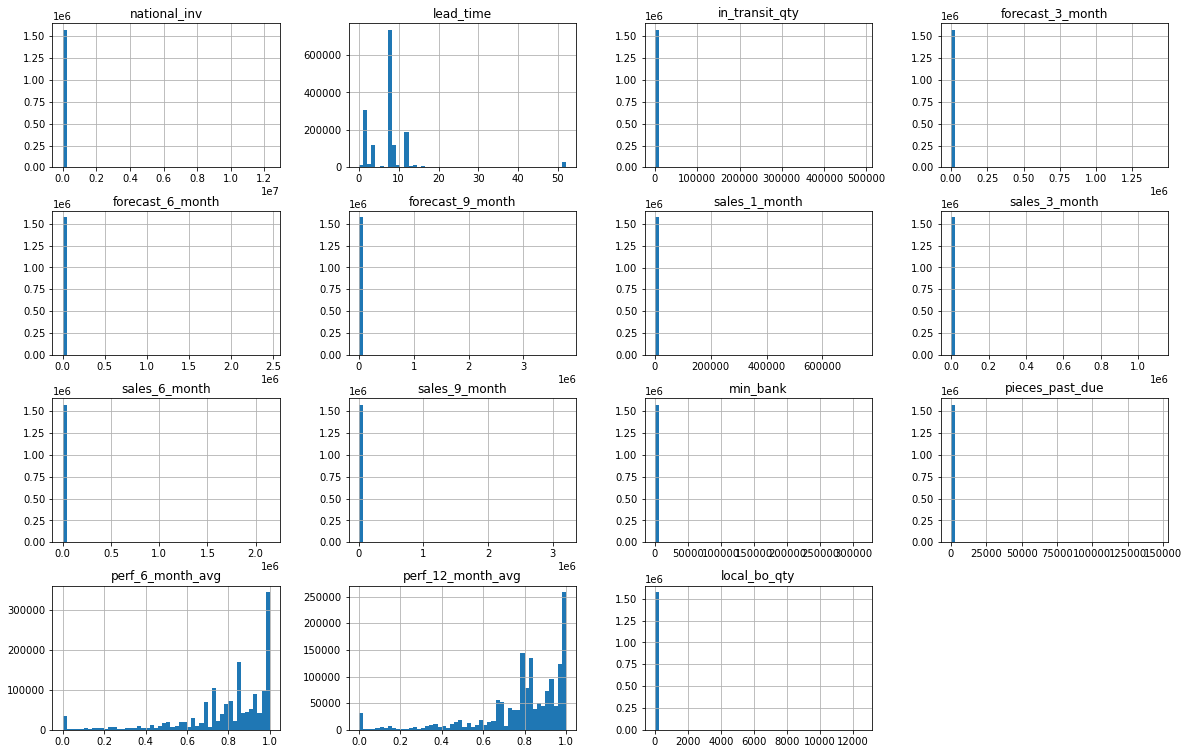

In [16]:
bo.hist(bins=50,figsize=(20,13))
plt.show()

In [17]:
bo.went_on_backorder.value_counts()

No     1567097
Yes       6450
Name: went_on_backorder, dtype: int64

In [18]:
##Does the current inventory level have any effect onresulting backorders?

bo_yes = bo[bo['went_on_backorder'] =='Yes']['national_inv']
bo_no = bo[bo['went_on_backorder'] =='No']['national_inv']

In [19]:
##step1:
##null hypothesis : the current inventory level doesn't have any effect on resulting backorders
##alternate hypothesis : the current inventory level does have effect on resulting backorders

In [20]:
##step2:significance alpha level of 5%

In [21]:
from scipy.stats import ttest_ind
stat,pval = ttest_ind(bo_yes,bo_no)


In [22]:
if pval < 0.05:
    print('reject null')
    
else:
    print('Fail to reject null')

Fail to reject null


In [23]:
## conclusion : The current inventory level doesn't have any effect on resulting backorders

In [24]:
## Are the lead time factors producing backorders?

Null hypothesis : avg lead_time of products not resulting in backorders = avg lead_time of products resulting in backorders

alternate hypothesis :avg lead_time of products not resulting in backorders != avg lead_time of products resulting in backorders

In [25]:
bo_yes = bo[bo['went_on_backorder'] =='Yes']['lead_time']
bo_no = bo[bo['went_on_backorder'] =='No']['lead_time']

In [26]:
from scipy.stats import ttest_ind
stat,pval = ttest_ind(bo_yes,bo_no)

In [27]:
if pval < 0.05:
    print('reject null')
    
else:
    print('Fail to reject null')

reject null


In [28]:
##conclusion:avg lead_time of products not resulting in backorders is not equal to avg lead_time of products resulting in backorders

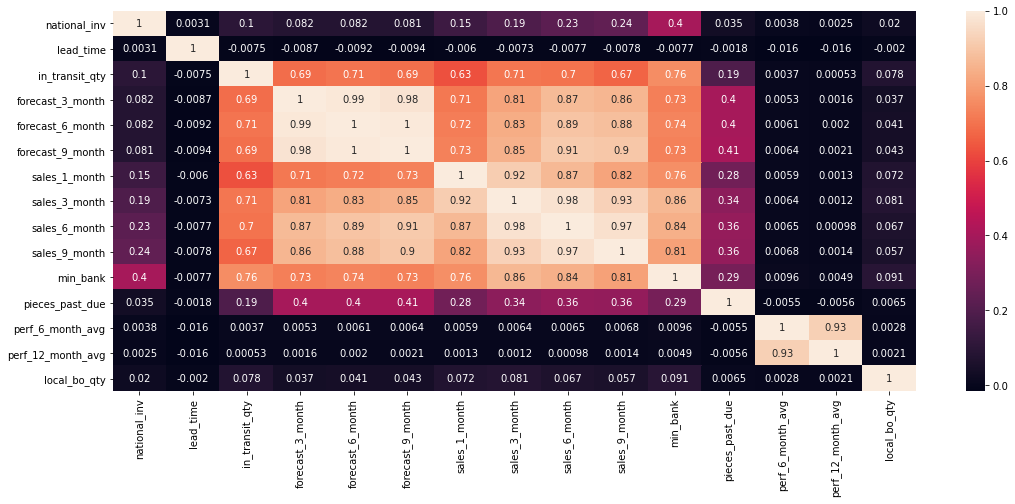

In [29]:
plt.figure(figsize=(18,7))
sns.heatmap(bo.corr(),annot=True)
plt.show()

##observations:
*There seems to be high correlation with the forescasted sales and sales_quantity.

In [30]:
ct = pd.crosstab(bo.deck_risk,bo.went_on_backorder)
ct

went_on_backorder,No,Yes
deck_risk,,
No,1220848,5670
Yes,346249,780


In [31]:
from scipy.stats import chi2_contingency
stat,pval,df,expect = chi2_contingency(ct)
pval

3.692628241510158e-83

In [32]:
x = bo.drop(columns='went_on_backorder',axis=1)
y = bo['went_on_backorder']

In [33]:
bo_new = pd.get_dummies(x,drop_first=True)
bo_new.head(3)

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,potential_issue_Yes,deck_risk_Yes,oe_constraint_Yes,ppap_risk_Yes,stop_auto_buy_Yes,rev_stop_Yes
sku,,,,,,,,,,,,,,,,,,,,,
1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99,0.99,0.0,0,0,0,0,1,0
1043696,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.85,0.83,0.0,0,1,0,0,1,0
1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.10,0.13,0.0,0,0,0,0,1,0


In [34]:
x = bo_new
y = bo['went_on_backorder']

In [35]:
y = y.map({'No':0,'Yes':1})

In [36]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
x_res,y_res = smote.fit_sample(x,y)

In [37]:
x.shape

(1573547, 21)

In [38]:
x_res.shape

(3134194, 21)

In [39]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0: 1567097, 1: 6450})
Resampled dataset shape Counter({0: 1567097, 1: 1567097})


In [40]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(x_res,y_res,test_size=0.3,random_state=10)

In [41]:
##Applying power transformer
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
pt.fit(xtrain)

PowerTransformer()

In [42]:
new_train = pt.transform(xtrain)
new_test = pt.transform(xtest)

### DecisionTree

In [43]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth = 10)
dt.fit(new_train,ytrain)


DecisionTreeClassifier(max_depth=10)

In [44]:
pred_dt = dt.predict(new_test)

In [45]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score,roc_curve

In [46]:
accuracy_score(ytest,pred_dt)

0.9243144708000668

<AxesSubplot:>

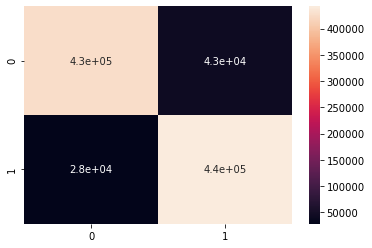

In [47]:
sns.heatmap(confusion_matrix(ytest,pred_dt),annot=True)

In [48]:
print(classification_report(ytest,pred_dt))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92    469915
           1       0.91      0.94      0.93    470344

    accuracy                           0.92    940259
   macro avg       0.92      0.92      0.92    940259
weighted avg       0.92      0.92      0.92    940259



In [49]:
y_pred_dt = dt.predict_proba(new_test)[:,1]
y_pred_dt

array([0.03045918, 0.57180913, 0.96887749, ..., 0.17955774, 0.00392604,
       0.89546036])

In [50]:
from sklearn.metrics import roc_curve

In [51]:
roc_auc_score(ytest,pred_dt)

0.9243069152849097

In [52]:
fpr,tpr,threshold = roc_curve(ytest,y_pred_dt)

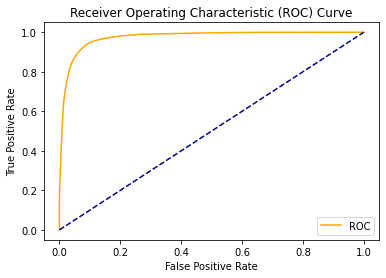

In [53]:
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [54]:
from sklearn.metrics import precision_recall_curve
precision,recall,threshold = precision_recall_curve(ytest,y_pred_dt)

In [55]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.grid(True)

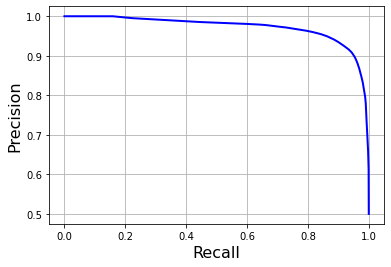

In [56]:
plot_precision_vs_recall(precision,recall)

### Observations:
* From the above plot we can see that precision really starts to fall sharply around 90%.we probably want to select a precision/recall trade-off that before that

### Hyperparameter Tuning

In [57]:
dt = DecisionTreeClassifier()

In [58]:
from sklearn.model_selection import GridSearchCV
param_grid = {'criterion':['gini'],'max_depth':[6,7,8,10,12],'min_samples_leaf':[5]}
gs = GridSearchCV(dt,param_grid,cv=5)

In [59]:
gs.fit(new_train,ytrain)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': [6, 7, 8, 10, 12],
                         'min_samples_leaf': [5]})

In [60]:
gs.best_params_

{'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 5}

In [61]:
gs.best_score_

0.9472144799185026

In [62]:
##Training the model with the best parameter
from sklearn.tree import DecisionTreeClassifier
new_dt = DecisionTreeClassifier(max_depth = 12,min_samples_leaf=5)
new_dt.fit(new_train,ytrain)

DecisionTreeClassifier(max_depth=12, min_samples_leaf=5)

In [63]:
new_pred_dt = new_dt.predict(new_test)

In [64]:
accuracy_score(ytest,new_pred_dt)

0.9470496958816667

In [65]:
##confusion_matrix
cm = confusion_matrix(ytest,new_pred_dt)
cm

array([[435691,  34224],
       [ 15563, 454781]], dtype=int64)

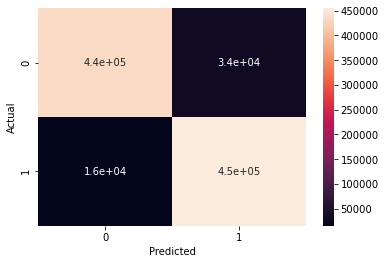

In [66]:
sns.heatmap(confusion_matrix(ytest,new_pred_dt),annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

* `True Positivies(TP)` : Model correctly predicted that the product will go backorder and the customer needs this now.The     benefit is profit.

* `True Negative (TN)` : Model correctly predicted that the product will not go backorder and the benefit is zero because
  the customer doesn't buy the product.
  
* `False Positivies(FP)` : Model incorrectly predicted that the product will go backorder,this is classifying a product as     backordered when the demand is not present and it will increase the warehousing and inventory related cost

* `False Negative (FN)` : Model incorrectly predicted that the product will not go backorder when the demand is present.This will lead to customer loss.

In [67]:
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

#### Sensitivity
* When the actual value is positive,how often is the prediction correct

In [68]:
sensitivity = TP/(TP+FN)
sensitivity

0.9669114520436106

#### Specificity
* When the actual value is negative, how often is the prediction correct



In [69]:
specificity = TN/(TN+FP)
specificity

0.9271698073055765

#### Precision
* When a positive value is predicted, how often is the prediction correct

In [70]:
Precision = TP/(TP+FP)
Precision

0.930012985552295

In [71]:
print(classification_report(ytest,new_pred_dt))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95    469915
           1       0.93      0.97      0.95    470344

    accuracy                           0.95    940259
   macro avg       0.95      0.95      0.95    940259
weighted avg       0.95      0.95      0.95    940259



In [72]:
new_y_pred_dt = new_dt.predict_proba(new_test)[:,1]
new_y_pred_dt

array([0.00150466, 0.2778626 , 0.97765724, ..., 0.2436212 , 0.        ,
       0.95953757])

In [73]:
roc_auc_score(ytest,new_pred_dt)

0.9470406296745936

In [74]:
fpr,tpr,threshold = roc_curve(ytest,new_y_pred_dt)

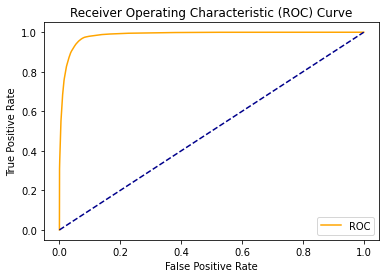

In [75]:
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()